The following is a simple backtest of a betting strategy based on the Kelly criteron. I'll try to compare different ratios of the criterion and see which has the best returns.

This experiment is inspired by the following [paper](http://www.edwardothorp.com/wp-content/uploads/2016/11/KellySimulationsNew.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
df = pd.read_csv('epl_odds.csv')

The columns we need are:
- FTR - Full time result (either **H**ome or **A**way)
- AvgH - average odds for the home team to win
- AvgA - average odds for the away team to win
- AvgD - average odds for a draw

In [3]:
o_cols = ['FTR', 'AvgH', 'AvgA', 'AvgD']
df = df.filter(o_cols)

To better understand the data, and to possibly find a method of picking the winning team. We can plot a histogram of the odds of the winning teams.

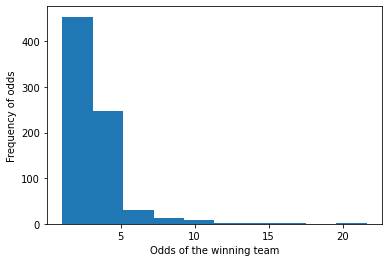

DescribeResult(nobs=760, minmax=(1.07, 21.61), mean=2.975407894736842, variance=3.835364523784758, skewness=3.399376543310549, kurtosis=19.482947166818523)

In [4]:
df_train = pd.concat(map(pd.read_csv, ['epl_odds_2019.csv', 'epl_odds_2020.csv']), ignore_index=True)
df_train = df_train.filter(o_cols)
ideal_odds = np.zeros(len(df_train))

for i, row in df_train.iterrows():
    ideal_odds[i] = row['Avg'+row['FTR']]

plt.hist(ideal_odds)
plt.xlabel("Odds of the winning team")
plt.ylabel("Frequency of odds")
plt.show()

scipy.stats.describe(ideal_odds)

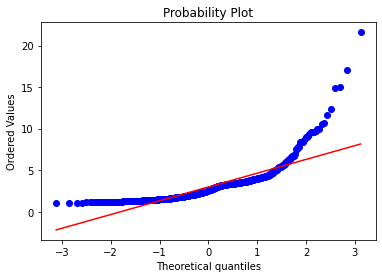

In [5]:
_ = scipy.stats.probplot(ideal_odds, plot=plt)

Assume we start with a balance of $100.

The strategy is to pick the outcome with the highest probability (lowest odds) and place Kelly bets on the outcome.

The formula for placing Kelly bets,
$f = p + \frac{p-1}{b}$

- where $f$ is the fraction of our capital we bet
- $p$ is the probability of winning
- $b$ is the ratio of return (i.e 2-to-1 = 2.0)

In [6]:
def run_kelly(k_factor, can_plot):
    starting_bal = 100
    bal = starting_bal
    bet = 0
    
    bal_history = np.zeros(len(df))
    result_history = ['w']*len(df)
    
    outcomes = ['H', 'A', 'D']
    for i, row in df.iterrows():
        all_odds = row.drop('FTR')
        
        bal_history[i] = bal
        
        idx = np.argmin(all_odds) + 1
        odds = row[idx]
        if odds > np.quantile(ideal_odds, 0.25):
            continue

        p = scipy.stats.percentileofscore(ideal_odds, odds)/100
        
        bet = (p + (p-1)/odds)*k_factor
        
        bet_amt = bet*bal
        bal -= bet_amt
        
        if row['FTR'] == outcomes[idx-1]:
            #print(f"Made ${(bet_amt*odds):.2f}, betting ${(bet_amt):.2f} with balance ${(bal):.2f}, odds {odds}")
            bal += bet_amt*odds
            result_history[i] = 'g'
        else:
            result_history[i] = 'r'
            #print(f"Lost ${bet_amt:.2f} with balance ${(bal + bet_amt):.2f}, odds {odds}")

        if bal <= 0:
            break
            
    def generate_plots():
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [10, 1], 'hspace': 0})

        #axs[0].plot(bal_history)
        axs[0].plot(np.log(bal_history))

        for i, col in enumerate(result_history):
            axs[1].scatter(i, 0, c=col, marker='|', linewidths=[0.8])

        axs[1].axes.get_yaxis().set_visible(False)
        axs[1].axes.get_xaxis().set_visible(False)
        plt.show()

        bet_acc = result_history.count('g')/(result_history.count('g') + result_history.count('r'))*100
        print(f"Final balance of ${bal:.2f} with a maximum of ${max(bal_history):.2f}")
        print(f"This strategy had a winning rate of {bet_acc:.2f}%")

    if can_plot:
        generate_plots()
    
    return bal

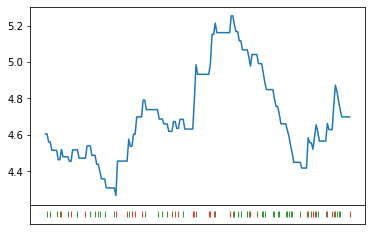

Final balance of $117.95 with a maximum of $191.33
This strategy had a winning rate of 67.57%


117.94963304397155

In [7]:
run_kelly(0.25, True)

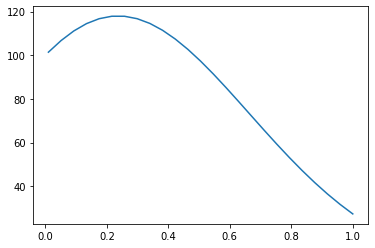

In [8]:
factors = np.linspace(0.01, 1, 25)
bals = np.empty(len(factors))

for i in range(len(factors)):
    bals[i] = run_kelly(factors[i], False)
    
plt.plot(factors, bals)